In [1]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
import base64
import pandas as pd

from PIPE_X.analyzer import Analyzer

In [4]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# setup

In [5]:
import os
from os import path

CONFIG_BASE_PATH = '../../experiments/yaml_files'
DATA_BASE_PATH = '../../data'
PIPELINE_BASE_PATH = '../../pipelines/pickles'
PLOTS_PATH = '../../experiments/plots'
SUMMARIES_PATH = '../../experiments/summaries'

SAMPLE_SIZE_TARGET = 500

os.makedirs(PLOTS_PATH, exist_ok=True)
os.makedirs(SUMMARIES_PATH, exist_ok=True)

MODEL_NAMES = [
    'LR',
    'DT',
    'GBT',
    'KNN',
    'HGB',
    'NN',
    'SVC',
]

MODELS_NAN = [  # restrict to models able to handle NaN
    'DT',
    'GBT',
    'HGB'
]

EXPERIMENT_CONFIGS = [
    ('AC', './experiments/yaml_files/exp_FPP_adult.yaml'),
    ('GC', './experiments/yaml_files/exp_FPP_german.yaml'),
    ('BM', './experiments/yaml_files/exp_FPP_bank.yaml'),
    ('TT', './experiments/yaml_files/exp_FPP_titanic.yaml'),
]

METRICS = [
    'immediate_impact',
    'leave_out_impact',
]

THRESHOLD_NEAR_ZERO = 0.1

## Definitions

In [6]:
def impacts_heatmap(aggregated_impacts):
    heatmap = np.array([aggregated_impacts[m] for m in METRICS])

    fig, ax = plt.subplots(figsize=(3, 1))
    sns.heatmap(data=heatmap, ax=ax, linecolor="white", linewidths=1, cbar=False, cmap='icefire', center=0)
    #plt.colorbar(label='Wert')
    ax.set_yticks([])
    ax.set_xticks([])

    # Plot als Bild in Bytes speichern
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    return img_base64

In [7]:
def img_tag(img_base64):
    return f'<img src="data:image/png;base64,{img_base64}" width="100"/>'

In [8]:
def aligmnent(v):
    return 2 * abs(np.sum([1 for value in v if value >= 0]) / len(v) - 0.5)

In [9]:
def compute_stats(result):
    pipeline_steps = result['pipeline_steps']
    pipeline_is_essential = result['pipeline_is_essential']
    pipeline_steps_reduced = [step for step, is_essential in zip(pipeline_steps, pipeline_is_essential) if not is_essential]

    stats = {}

    for m in METRICS:
        stats[m] = {
            'std_values': [],
            'alignment_values': [],
            'avg_impact_values': [],
        }
        for i, step in enumerate(pipeline_steps_reduced):
            step_impacts = [impacts[m][i] for impacts in result['impacts'].values()]
            stats[m]['avg_impact_values'].append(np.mean(step_impacts))
            stats[m]['alignment_values'].append(aligmnent(step_impacts))
            stats[m]['std_values'].append(np.std(step_impacts))

        stats[m]['alignment'] = f"{np.mean(stats[m]['alignment_values']):.3f} ± {np.std(stats[m]['alignment_values']):.3f}"
        stats[m]['avg impact'] = f"{np.mean(stats[m]['avg_impact_values']):.3f} ± {np.std(stats[m]['avg_impact_values']):.3f}"
        stats[m]['divergence'] = f"{np.mean(stats[m]['std_values']):.3f} ± {np.std(stats[m]['std_values']):.3f}"
        stats[m]['close_to_zero'] = str(sum([1 for v in stats[m]['avg_impact_values'] if abs(v) < THRESHOLD_NEAR_ZERO]))
        stats[m]['negative'] = str(sum([1 for v in stats[m]['avg_impact_values'] if v < 0]))
        stats[m]['quartiles'] = ', '.join(f"{s:.3f}" for s in np.quantile(stats[m]['avg_impact_values'], [0.25, 0.50, 0.75]).tolist())

    count_steps = len([s for s in pipeline_steps if s != 'noop'])
    count_steps_inspectable = len(pipeline_steps_reduced)
    if result['model'] == 'GBT':
        global_stats['lengths'].append(count_steps)
        global_stats['inspectable_steps'].append(count_steps_inspectable)

    return {
        'alignment':
            f"{stats['immediate_impact']['alignment']} / {stats['leave_out_impact']['alignment']}",
        'avg impact':
            f"{stats['immediate_impact']['avg impact']} / {stats['leave_out_impact']['avg impact']}",
        'divergence':
            f"{stats['immediate_impact']['divergence']} / {stats['leave_out_impact']['divergence']}",
        'steps ± 0':
            f"{stats['immediate_impact']['close_to_zero']} / {stats['leave_out_impact']['close_to_zero']}",
        'steps < 0':
            f"{stats['immediate_impact']['negative']} / {stats['leave_out_impact']['negative']}",
        'quartiles':
            f"{stats['immediate_impact']['quartiles']} / {stats['leave_out_impact']['quartiles']}",
        'no steps': f"{count_steps_inspectable} ({count_steps})",
    }

In [10]:
def split_rows(df):
    new_rows = []
    for _, row in df.iterrows():
        row1 = row.copy()
        row2 = row.copy()
        for col in df.columns:
            val = row[col]
            if col != "Impacts" and isinstance(val, str) and '/' in val:
                parts = val.split('/', 1)
                row1[col] = parts[0].strip()
                row2[col] = parts[1].strip()
            else:
                row2[col] = ""  # Zellen leer lassen
        new_rows.append(row1)
        new_rows.append(row2)
    return pd.DataFrame(new_rows, columns=df.columns)

In [11]:
def summary_experiment_series(name, exp_config_path):
    analyzer = Analyzer('../..', exp_config_path, './experiments')
    analyzer.load_results()

    df = pd.DataFrame(analyzer.results)

    columns_to_display = ['experiment', 'no samples', 'no steps', 'plot', 'range', 'alignment', 'avg impact', 'divergence',
                          'steps ± 0', 'steps < 0', 'quartiles', 'model', 'time_measures']
    df = df[df['sample_size'] == SAMPLE_SIZE_TARGET]
    df = df.sort_values(by=['model', 'experiment'])
    df['no samples'] = df['impacts'].apply(len)
    df['plot'] = df['aggregated_impacts'].apply(impacts_heatmap)
    df['range'] = df['aggregated_impacts'].apply(lambda
                                                     x: f"{min(x['immediate_impact']):.3f} -- {max(x['immediate_impact']):.3f}  / {min(x['leave_out_impact']):.3f} -- {max(x['leave_out_impact']):.3f}")
    applied_df = df.apply(lambda x: compute_stats(x), axis='columns', result_type='expand')
    df = pd.concat([df, applied_df], axis='columns')
    df = df[columns_to_display].rename(columns={
        'experiment': 'Exp.',
        'no samples': '# of Samples',
        'no steps': '# of Steps',
        'plot': 'Impacts',
        'range': 'Range',
        'alignment': 'Alignment',
        'avg impact': '⌀ Impact',
        'divergence': 'Divergence',
        'steps ± 0': 'Steps ≈ 0',
        'steps < 0': 'Steps < 0',
        'quartiles': 'Quartiles (25%, 50%, 75%)',
        'model': 'Model',
    })
    # Delete existing summary file if exists
    summary_file_path = path.join(SUMMARIES_PATH, f'{name}.xlsx')
    if path.exists(summary_file_path):
        os.remove(summary_file_path)
    with pd.ExcelWriter(summary_file_path, engine="openpyxl") as writer:
        for model in MODEL_NAMES:
            df_export = df[df['Model'] == model].drop(['Model', 'time_measures'], axis=1)
            if df_export.empty:
                continue

            plot_export_path = path.join(PLOTS_PATH, model)
            os.makedirs(plot_export_path, exist_ok=True)
            for index, row in df_export.iterrows():
                img_data = base64.b64decode(row['Impacts'])
                with open(path.join(plot_export_path, f"{row['Exp.']}.png"), "wb") as f:
                    f.write(img_data)

            df_export['Impacts'] = df_export.apply(lambda x: '\\multirow[b]{2}{*}{\\includegraphics[width=8em,height=1.9em]{impact_plots/' + model + "/" + x['Exp.'] + ".png}}", axis=1)
            df_export = df_export.rename(columns={
                '⌀ Impact': '\\varnothing Impact',
                'Steps ≈ 0': 'Steps \\approx 0',
            })
            df_export = split_rows(df_export)
            df_export.to_excel(writer, sheet_name=model)

    df_styled = df.drop('time_measures', axis=1).style.format({'Impacts': img_tag}).hide(axis="index")
    display(df_styled)

    return df


## Aggregate Experiments

Loaded ./experiments/yaml_files/exp_FPP_adult.yaml
Measures: immediate_impact, leave_out_impact


Exp.,# of Samples,# of Steps,Impacts,Range,Alignment,⌀ Impact,Divergence,Steps ≈ 0,Steps < 0,"Quartiles (25%, 50%, 75%)",Model
AC01,495,3 (5),,-0.009 -- 0.590 / 0.319 -- 0.686,0.663 ± 0.456 / 0.956 ± 0.040,0.333 ± 0.252 / 0.494 ± 0.150,0.196 ± 0.015 / 0.198 ± 0.009,1 / 0,1 / 0,"0.205, 0.419, 0.504 / 0.398, 0.476, 0.581",DT
AC02,495,4 (6),,-0.008 -- 0.497 / 0.436 -- 0.496,0.522 ± 0.429 / 0.926 ± 0.010,0.250 ± 0.224 / 0.459 ± 0.025,0.268 ± 0.030 / 0.258 ± 0.008,2 / 0,1 / 0,"0.046, 0.255, 0.459 / 0.436, 0.451, 0.474",DT
AC03,495,4 (5),,-0.004 -- 0.764 / 0.032 -- 0.752,0.739 ± 0.376 / 0.831 ± 0.193,0.250 ± 0.303 / 0.269 ± 0.290,0.053 ± 0.007 / 0.051 ± 0.007,2 / 2,1 / 0,"0.056, 0.120, 0.313 / 0.048, 0.147, 0.368",DT
AC04,495,3 (5),,-0.009 -- 0.590 / 0.319 -- 0.686,0.663 ± 0.456 / 0.956 ± 0.040,0.333 ± 0.252 / 0.494 ± 0.150,0.196 ± 0.015 / 0.198 ± 0.009,1 / 0,1 / 0,"0.205, 0.419, 0.504 / 0.398, 0.476, 0.581",DT
AC05,495,2 (4),,0.407 -- 0.593 / 0.346 -- 0.602,0.939 ± 0.032 / 0.889 ± 0.103,0.500 ± 0.093 / 0.474 ± 0.128,0.253 ± 0.000 / 0.267 ± 0.038,0 / 0,0 / 0,"0.454, 0.500, 0.546 / 0.410, 0.474, 0.538",DT
AC06,495,5 (6),,-0.020 -- 0.976 / -0.003 -- 0.938,0.487 ± 0.341 / 0.391 ± 0.339,0.200 ± 0.388 / 0.187 ± 0.376,0.031 ± 0.016 / 0.012 ± 0.017,4 / 4,2 / 4,"-0.001, 0.002, 0.043 / -0.001, -0.000, -0.000",DT
AC07,495,7 (9),,-0.121 -- 0.707 / 0.018 -- 0.846,0.755 ± 0.212 / 0.480 ± 0.251,0.143 ± 0.243 / 0.154 ± 0.283,0.079 ± 0.006 / 0.077 ± 0.003,3 / 6,1 / 0,"0.047, 0.077, 0.122 / 0.025, 0.050, 0.056",DT
AC08,495,5 (6),,0.035 -- 0.430 / 0.192 -- 0.792,0.842 ± 0.144 / 0.808 ± 0.152,0.200 ± 0.129 / 0.405 ± 0.203,0.132 ± 0.085 / 0.183 ± 0.065,1 / 0,0 / 0,"0.159, 0.166, 0.210 / 0.324, 0.348, 0.371",DT
AC09,495,4 (5),,-0.009 -- 0.818 / 0.095 -- 0.941,0.698 ± 0.329 / 0.776 ± 0.135,0.250 ± 0.331 / 0.320 ± 0.358,0.072 ± 0.028 / 0.077 ± 0.023,2 / 1,1 / 0,"0.052, 0.096, 0.293 / 0.110, 0.123, 0.334",DT
AC10,495,5 (6),,-0.022 -- 0.849 / 0.109 -- 0.989,0.640 ± 0.258 / 0.846 ± 0.083,0.200 ± 0.329 / 0.296 ± 0.347,0.060 ± 0.027 / 0.080 ± 0.020,3 / 0,1 / 0,"0.013, 0.031, 0.129 / 0.120, 0.125, 0.138",DT

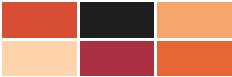
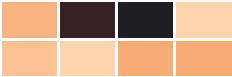
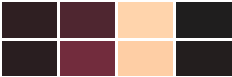
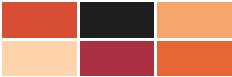
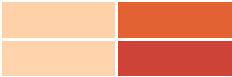
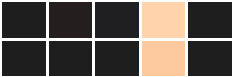
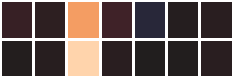
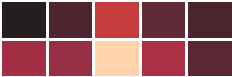
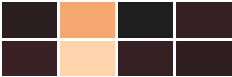
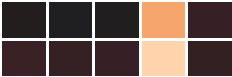
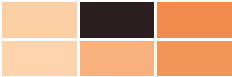
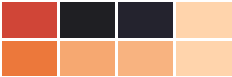
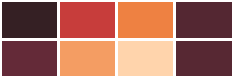
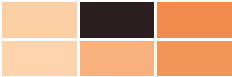
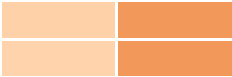
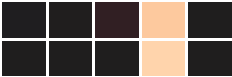
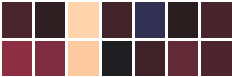
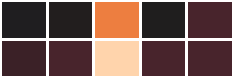
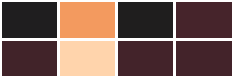
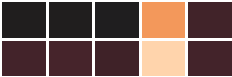
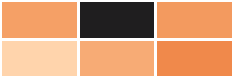
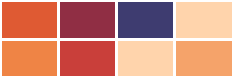
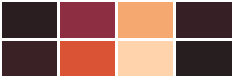
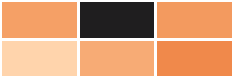
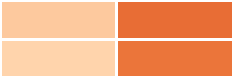
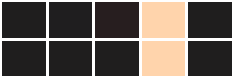
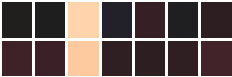
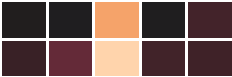
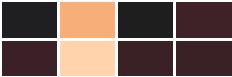
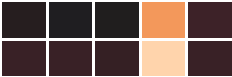

Loaded ./experiments/yaml_files/exp_FPP_german.yaml
Measures: immediate_impact, leave_out_impact


Exp.,# of Samples,# of Steps,Impacts,Range,Alignment,⌀ Impact,Divergence,Steps ≈ 0,Steps < 0,"Quartiles (25%, 50%, 75%)",Model
GC01,373,8 (9),,0.010 -- 0.415 / -0.028 -- 0.417,0.790 ± 0.270 / 0.454 ± 0.301,0.125 ± 0.130 / 0.041 ± 0.142,0.046 ± 0.007 / 0.030 ± 0.012,6 / 7,0 / 6,"0.051, 0.071, 0.127 / -0.018, -0.012, 0.000",DT
GC02,373,10 (11),,-0.008 -- 0.432 / -0.029 -- 0.660,0.524 ± 0.367 / 0.893 ± 0.219,0.100 ± 0.137 / 0.222 ± 0.178,0.061 ± 0.020 / 0.075 ± 0.016,7 / 2,2 / 1,"0.014, 0.034, 0.145 / 0.122, 0.189, 0.258",DT
GC03,373,9 (10),,-0.014 -- 0.569 / 0.072 -- 0.575,0.641 ± 0.353 / 0.993 ± 0.019,0.111 ± 0.176 / 0.298 ± 0.167,0.034 ± 0.004 / 0.046 ± 0.006,7 / 1,1 / 0,"0.011, 0.040, 0.074 / 0.150, 0.324, 0.353",DT
GC04,373,8 (10),,-0.057 -- 0.407 / 0.100 -- 0.342,0.645 ± 0.334 / 0.945 ± 0.077,0.125 ± 0.150 / 0.231 ± 0.075,0.096 ± 0.009 / 0.095 ± 0.006,4 / 0,2 / 0,"0.005, 0.096, 0.236 / 0.205, 0.232, 0.277",DT
GC05,373,9 (10),,-0.036 -- 0.629 / 0.065 -- 0.715,0.753 ± 0.318 / 0.988 ± 0.020,0.111 ± 0.190 / 0.219 ± 0.191,0.045 ± 0.008 / 0.052 ± 0.013,7 / 3,3 / 0,"-0.007, 0.083, 0.099 / 0.085, 0.160, 0.214",DT
GC06,373,9 (11),,-0.019 -- 0.764 / 0.142 -- 0.732,0.585 ± 0.298 / 1.000 ± 0.000,0.111 ± 0.233 / 0.323 ± 0.185,0.040 ± 0.004 / 0.053 ± 0.006,8 / 0,2 / 0,"0.017, 0.030, 0.061 / 0.197, 0.266, 0.317",DT
GC07,373,10 (11),,-0.037 -- 0.716 / -0.040 -- 1.214,0.627 ± 0.314 / 0.961 ± 0.064,0.100 ± 0.212 / 0.613 ± 0.498,0.027 ± 0.007 / 0.040 ± 0.012,8 / 3,3 / 1,"0.002, 0.019, 0.053 / 0.077, 0.661, 1.135",DT
GC08,373,9 (10),,-0.036 -- 0.629 / 0.065 -- 0.715,0.753 ± 0.318 / 0.988 ± 0.020,0.111 ± 0.190 / 0.219 ± 0.191,0.045 ± 0.008 / 0.052 ± 0.013,7 / 3,3 / 0,"-0.007, 0.083, 0.099 / 0.085, 0.160, 0.214",DT
GC09,373,9 (10),,-0.015 -- 0.407 / 0.029 -- 0.451,0.659 ± 0.313 / 0.983 ± 0.022,0.111 ± 0.123 / 0.124 ± 0.126,0.070 ± 0.019 / 0.051 ± 0.039,5 / 7,1 / 0,"0.023, 0.064, 0.128 / 0.063, 0.076, 0.099",DT
GC10,373,9 (10),,-0.027 -- 0.604 / 0.055 -- 0.617,0.715 ± 0.312 / 0.940 ± 0.062,0.111 ± 0.183 / 0.175 ± 0.176,0.043 ± 0.012 / 0.060 ± 0.020,6 / 5,2 / 0,"0.012, 0.043, 0.101 / 0.062, 0.083, 0.232",DT

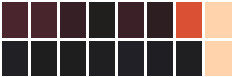
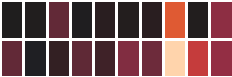
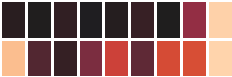
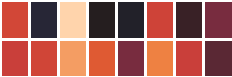
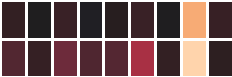
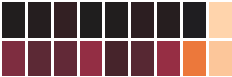
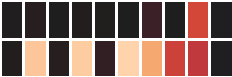
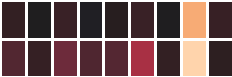
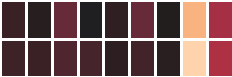
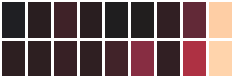
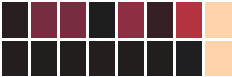
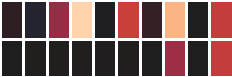
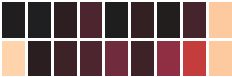
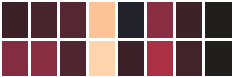
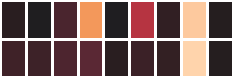
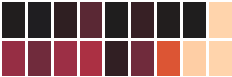
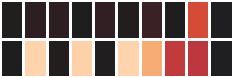
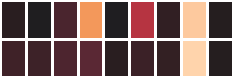
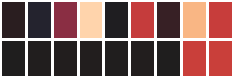
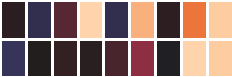
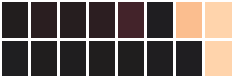
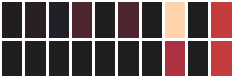
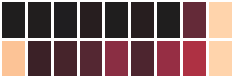
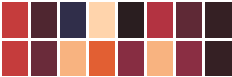
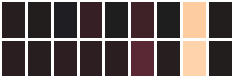
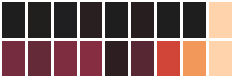
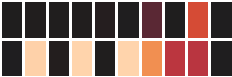
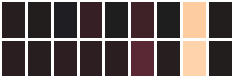
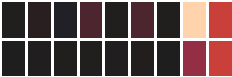
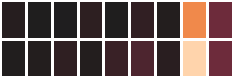
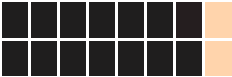
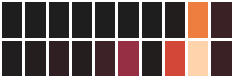
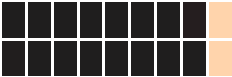
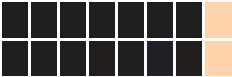
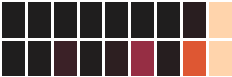
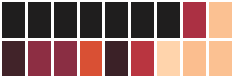
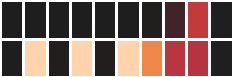
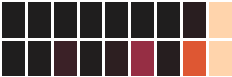
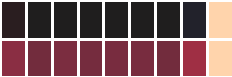
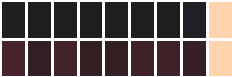
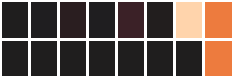
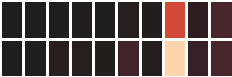
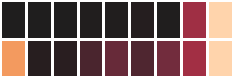
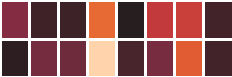
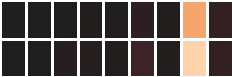
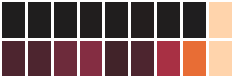
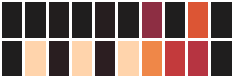
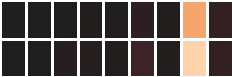
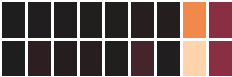
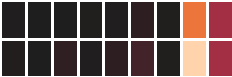
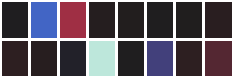
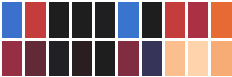
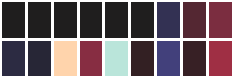
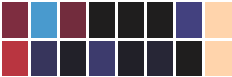
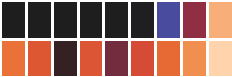
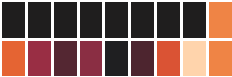
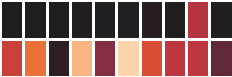
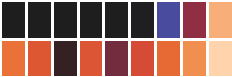
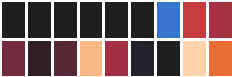
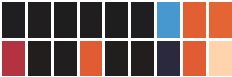
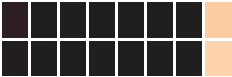
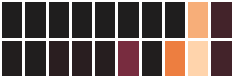
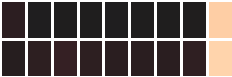
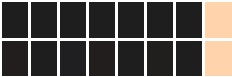
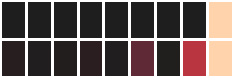
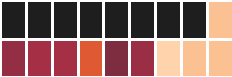
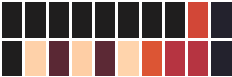
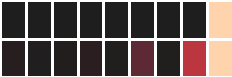
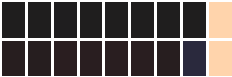
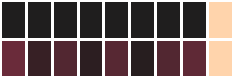

Loaded ./experiments/yaml_files/exp_FPP_bank.yaml
Measures: immediate_impact, leave_out_impact


Exp.,# of Samples,# of Steps,Impacts,Range,Alignment,⌀ Impact,Divergence,Steps ≈ 0,Steps < 0,"Quartiles (25%, 50%, 75%)",Model
BM01,495,5 (7),,0.031 -- 0.474 / 0.206 -- 0.381,0.577 ± 0.353 / 0.897 ± 0.074,0.200 ± 0.167 / 0.280 ± 0.063,0.164 ± 0.014 / 0.163 ± 0.014,2 / 0,0 / 0,"0.041, 0.159, 0.294 / 0.233, 0.260, 0.317",DT
BM02,495,2 (3),,0.410 -- 0.590 / 0.345 -- 0.743,0.988 ± 0.012 / 0.990 ± 0.010,0.500 ± 0.090 / 0.544 ± 0.199,0.163 ± 0.000 / 0.159 ± 0.002,0 / 0,0 / 0,"0.455, 0.500, 0.545 / 0.444, 0.544, 0.643",DT
BM03,495,7 (9),,-0.077 -- 0.508 / 0.100 -- 0.586,0.678 ± 0.288 / 0.871 ± 0.154,0.143 ± 0.195 / 0.268 ± 0.157,0.131 ± 0.010 / 0.126 ± 0.013,3 / 1,3 / 0,"-0.041, 0.191, 0.229 / 0.165, 0.208, 0.327",DT
BM04,495,5 (6),,0.011 -- 0.576 / 0.065 -- 0.605,0.819 ± 0.332 / 0.977 ± 0.020,0.200 ± 0.199 / 0.215 ± 0.206,0.082 ± 0.049 / 0.060 ± 0.039,2 / 3,0 / 0,"0.066, 0.153, 0.194 / 0.077, 0.086, 0.244",DT
BM05,495,4 (5),,0.003 -- 0.586 / 0.257 -- 0.778,0.729 ± 0.405 / 0.962 ± 0.036,0.250 ± 0.215 / 0.419 ± 0.212,0.101 ± 0.020 / 0.106 ± 0.020,1 / 0,0 / 0,"0.112, 0.206, 0.344 / 0.267, 0.321, 0.473",DT
BM06,495,5 (6),,-0.114 -- 0.554 / 0.196 -- 0.729,0.926 ± 0.084 / 0.977 ± 0.024,0.200 ± 0.216 / 0.372 ± 0.198,0.090 ± 0.013 / 0.096 ± 0.023,0 / 0,1 / 0,"0.106, 0.220, 0.234 / 0.225, 0.271, 0.440",DT
BM07,495,4 (5),,-0.026 -- 0.790 / 0.253 -- 0.842,0.669 ± 0.330 / 0.961 ± 0.029,0.250 ± 0.321 / 0.427 ± 0.241,0.082 ± 0.003 / 0.097 ± 0.015,2 / 0,1 / 0,"0.035, 0.118, 0.333 / 0.287, 0.306, 0.445",DT
BM08,495,4 (5),,-0.013 -- 0.814 / 0.179 -- 0.825,0.533 ± 0.445 / 0.978 ± 0.018,0.250 ± 0.334 / 0.414 ± 0.246,0.091 ± 0.003 / 0.099 ± 0.017,2 / 0,1 / 0,"0.006, 0.099, 0.344 / 0.263, 0.327, 0.479",DT
BM01,495,5 (7),,-0.290 -- 1.125 / -0.089 -- 1.159,0.833 ± 0.247 / 0.767 ± 0.193,0.200 ± 0.498 / 0.231 ± 0.472,0.094 ± 0.019 / 0.084 ± 0.014,1 / 3,2 / 2,"-0.133, 0.032, 0.265 / -0.085, 0.036, 0.133",GBT
BM02,495,2 (3),,0.339 -- 0.661 / 0.339 -- 0.391,0.994 ± 0.006 / 0.994 ± 0.002,0.500 ± 0.161 / 0.365 ± 0.026,0.126 ± 0.000 / 0.119 ± 0.006,0 / 0,0 / 0,"0.420, 0.500, 0.580 / 0.352, 0.365, 0.378",GBT

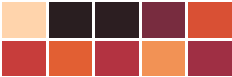
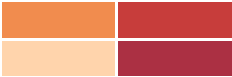
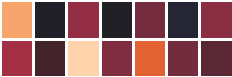
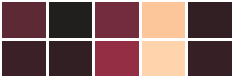
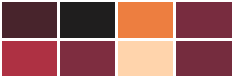
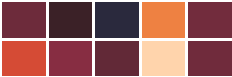
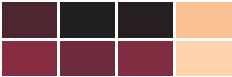
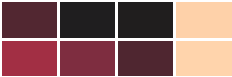
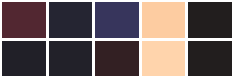
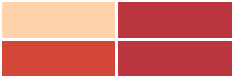
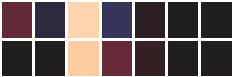
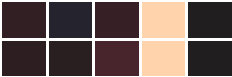
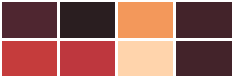
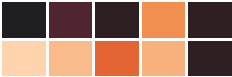
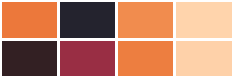
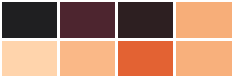
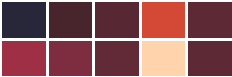
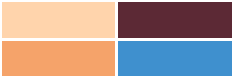
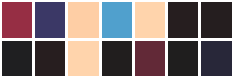
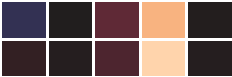
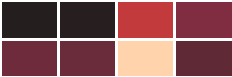
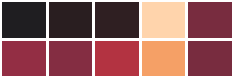
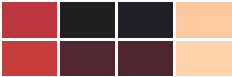
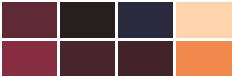

Loaded ./experiments/yaml_files/exp_FPP_titanic.yaml
Measures: immediate_impact, leave_out_impact


Exp.,# of Samples,# of Steps,Impacts,Range,Alignment,⌀ Impact,Divergence,Steps ≈ 0,Steps < 0,"Quartiles (25%, 50%, 75%)",Model
TT01,141,10 (12),,-0.104 -- 0.271 / 0.027 -- 0.584,0.773 ± 0.327 / 0.772 ± 0.249,0.100 ± 0.132 / 0.202 ± 0.193,0.062 ± 0.013 / 0.058 ± 0.013,4 / 4,3 / 0,"-0.001, 0.110, 0.226 / 0.031, 0.106, 0.373",DT
TT07,141,11 (13),,-0.103 -- 1.126 / -0.122 -- 0.884,0.661 ± 0.290 / 0.595 ± 0.348,0.091 ± 0.333 / 0.074 ± 0.261,0.035 ± 0.009 / 0.039 ± 0.004,8 / 9,7 / 6,"-0.042, -0.014, 0.015 / -0.025, -0.000, 0.042",DT
TT08,141,11 (13),,-0.513 -- 0.731 / 0.070 -- 0.807,0.917 ± 0.141 / 0.963 ± 0.076,0.091 ± 0.350 / 0.358 ± 0.218,0.089 ± 0.025 / 0.077 ± 0.022,2 / 2,4 / 0,"-0.047, 0.179, 0.258 / 0.160, 0.371, 0.488",DT
TT01,141,10 (12),,-0.011 -- 0.505 / -0.040 -- 0.904,0.562 ± 0.371 / 0.801 ± 0.292,0.100 ± 0.152 / 0.196 ± 0.271,0.038 ± 0.007 / 0.039 ± 0.007,6 / 5,3 / 1,"0.000, 0.025, 0.143 / 0.033, 0.083, 0.294",GBT
TT07,141,11 (13),,-0.060 -- 0.775 / 0.005 -- 0.889,0.531 ± 0.415 / 0.553 ± 0.355,0.091 ± 0.223 / 0.117 ± 0.248,0.025 ± 0.005 / 0.029 ± 0.003,9 / 9,3 / 0,"-0.000, 0.005, 0.057 / 0.007, 0.025, 0.078",GBT
TT08,141,11 (13),,-0.076 -- 0.789 / -0.212 -- 0.631,0.502 ± 0.326 / 0.634 ± 0.358,0.091 ± 0.229 / 0.122 ± 0.240,0.053 ± 0.019 / 0.064 ± 0.010,9 / 7,4 / 3,"-0.003, 0.015, 0.061 / 0.008, 0.030, 0.121",GBT
TT01,141,10 (12),,-0.027 -- 0.268 / -0.006 -- 0.805,0.736 ± 0.376 / 0.797 ± 0.338,0.100 ± 0.107 / 0.259 ± 0.265,0.024 ± 0.005 / 0.027 ± 0.005,6 / 4,2 / 1,"0.003, 0.077, 0.205 / 0.041, 0.167, 0.366",HGB
TT07,141,11 (13),,-0.041 -- 0.737 / 0.004 -- 0.813,0.674 ± 0.339 / 0.642 ± 0.373,0.091 ± 0.219 / 0.160 ± 0.230,0.018 ± 0.005 / 0.022 ± 0.002,9 / 6,4 / 0,"-0.007, 0.004, 0.025 / 0.006, 0.029, 0.231",HGB
TT08,141,11 (13),,-0.007 -- 0.548 / -0.072 -- 0.561,0.400 ± 0.354 / 0.502 ± 0.347,0.091 ± 0.159 / 0.085 ± 0.169,0.066 ± 0.014 / 0.060 ± 0.006,8 / 8,2 / 3,"0.003, 0.020, 0.083 / 0.005, 0.023, 0.096",HGB

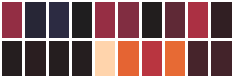
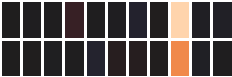
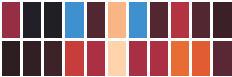
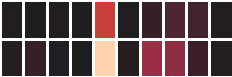
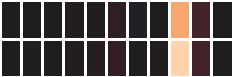
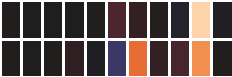
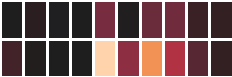
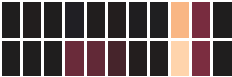
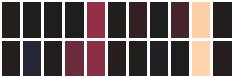

In [12]:
summary_dfs = {}
global_stats = {
    'lengths': [],
    'inspectable_steps': [],
}
for name, exp_config_path in EXPERIMENT_CONFIGS:
    summary_dfs[name] = summary_experiment_series(name, exp_config_path)


In [13]:
print(f"Processed {len(global_stats['lengths'])} pipelines.")
print(f"Average pipeline length: {np.mean(global_stats['lengths']):.2f}")
print(f"Average inspectable steps: {np.mean(global_stats['inspectable_steps']):.2f}")
print(f"Average ratio inspectable steps: {np.mean(np.array(global_stats['inspectable_steps']) / np.array(global_stats['lengths'])) *100:.2f}%")
print(f"Min pipeline length: {np.min(global_stats['inspectable_steps'])} ({np.min(global_stats['lengths'])})")
print(f"Max pipeline length: {np.max(global_stats['inspectable_steps'])} ({np.max(global_stats['lengths'])})")

Processed 31 pipelines.
Average pipeline length: 7.84
Average inspectable steps: 6.45
Average ratio inspectable steps: 80.07%
Min pipeline length: 2 (3)
Max pipeline length: 11 (13)


## Time Measures

In [14]:
# Runtime stats over different architectures

time_measures = {}
for name, df in summary_dfs.items():
    for _, result in df.iterrows():
        model = result['Model']
        if model not in time_measures:
            time_measures[model] = {
                'init_cycles': [],
                'init_seconds': [],
                'setup_cycles': [],
                'setup_seconds': [],
                'avg_cycles_per_run': [],
                'avg_seconds_per_run': [],
                'run_cycles': [],
                'run_seconds': [],
            }
        time_measures[model]['init_cycles'].append(result['time_measures']['init_cycles'])
        time_measures[model]['init_seconds'].append(result['time_measures']['init_seconds'])
        time_measures[model]['setup_cycles'].append(result['time_measures']['setup_cycles'])
        time_measures[model]['setup_seconds'].append(result['time_measures']['setup_seconds'])
        time_measures[model]['avg_cycles_per_run'].append(result['time_measures']['avg_cycles_per_run'])
        time_measures[model]['avg_seconds_per_run'].append(result['time_measures']['avg_seconds_per_run'])
        time_measures[model]['run_cycles'].append(result['time_measures']['run_cycles'])
        time_measures[model]['run_seconds'].append(result['time_measures']['run_seconds'])

measures_list = []
means = {}
stds = {}
for model, measures in time_measures.items():
    aggregated_measures = {
        'model': model,
    }

    for key, values in measures.items():
        if key not in means:
            means[key] = []
            stds[key] = []
        m = np.mean(values)
        std = np.std(values)
        aggregated_measures[key] = f"{m:.3f} ± {std:.3f}"
        means[key].append(m)
        stds[key].append(std)
    measures_list.append(aggregated_measures)

measures_list.append(
    {
        'model': 'AVERAGE',
        **{key: f"{np.mean(means[key]):.3f} ± {np.mean(stds[key]):.3f}" for key in means.keys()}
    }
)

df_measures = pd.DataFrame(measures_list)
display(df_measures)

,model,init_cycles,init_seconds,setup_cycles,setup_seconds,avg_cycles_per_run,avg_seconds_per_run,run_cycles,run_seconds
0,DT,0.018 ± 0.004,0.018 ± 0.004,2.613 ± 4.178,1.423 ± 1.550,2.011 ± 5.145,0.113 ± 0.070,1005.618 ± 2572.723,56.357 ± 35.111
1,GBT,0.018 ± 0.004,0.018 ± 0.003,1112.149 ± 329.368,9.429 ± 2.988,20.132 ± 19.843,0.196 ± 0.182,10065.869 ± 9921.675,97.905 ± 91.012
2,HGB,0.019 ± 0.004,0.019 ± 0.004,324.184 ± 114.103,5.833 ± 2.222,9.675 ± 6.620,0.160 ± 0.084,4837.573 ± 3309.937,79.786 ± 41.945
3,KNN,0.019 ± 0.001,0.019 ± 0.001,3.547 ± 3.564,0.262 ± 0.098,6.982 ± 1.053,0.221 ± 0.054,3491.073 ± 526.369,110.520 ± 26.870
4,LR,0.016 ± 0.001,0.016 ± 0.001,2.201 ± 3.018,0.291 ± 0.108,0.141 ± 0.047,0.141 ± 0.047,70.386 ± 23.658,70.343 ± 23.643
5,NN,0.017 ± 0.001,0.017 ± 0.001,2.766 ± 3.178,0.800 ± 0.208,8.576 ± 2.272,0.180 ± 0.046,4287.832 ± 1135.978,89.967 ± 22.988
6,SVC,0.015 ± 0.000,0.015 ± 0.000,54.352 ± 5.220,0.809 ± 0.090,4.596 ± 0.554,0.198 ± 0.045,2298.075 ± 277.005,99.087 ± 22.446
7,AVERAGE,0.017 ± 0.002,0.017 ± 0.002,214.545 ± 66.090,2.692 ± 1.038,7.445 ± 5.076,0.173 ± 0.075,3722.346 ± 2538.192,86.281 ± 37.716


## Generate legend

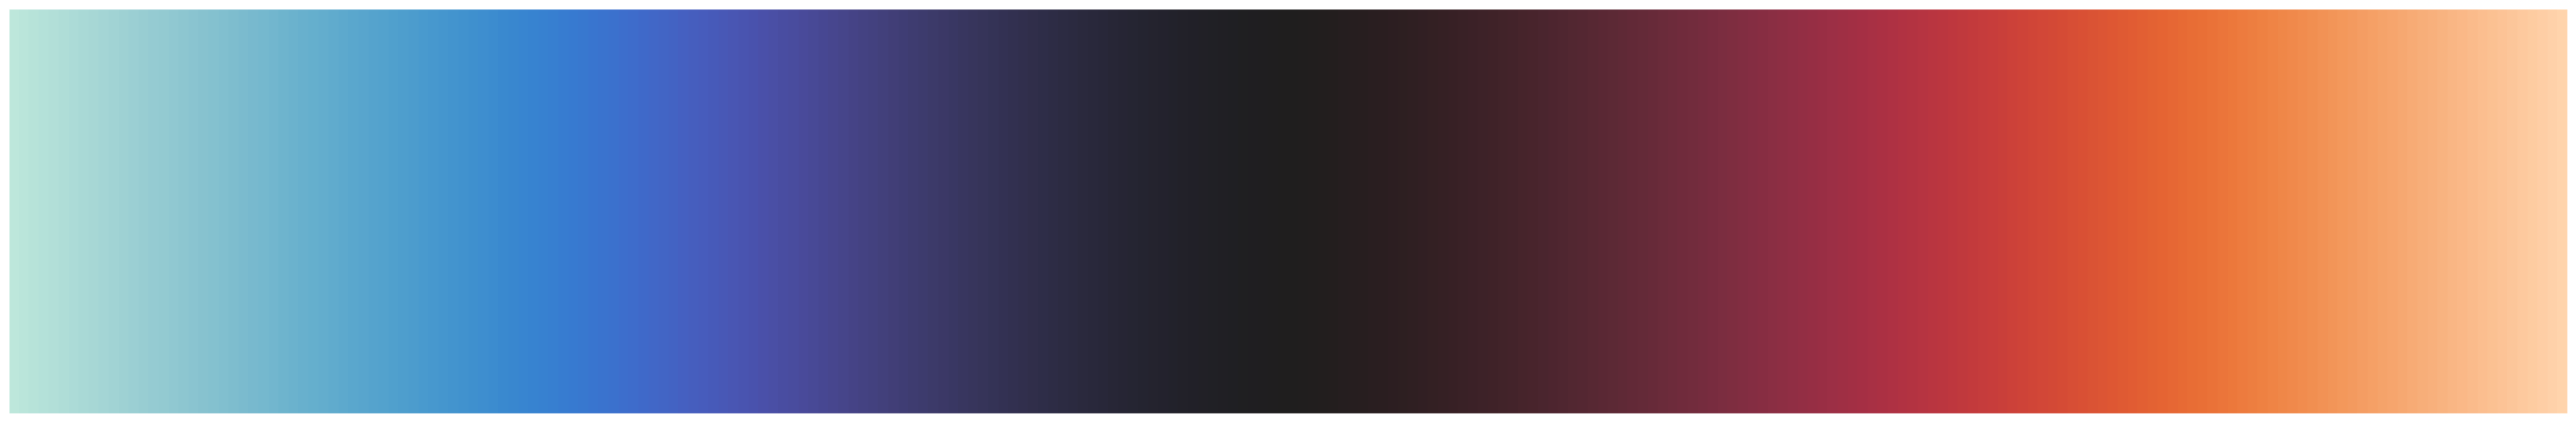

In [15]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(30, 5))
cmap = plt.get_cmap('icefire')
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('')
ax.set_xticks([])
plt.tight_layout()
plt.show()